データ読み込みとグラフ出力による確認

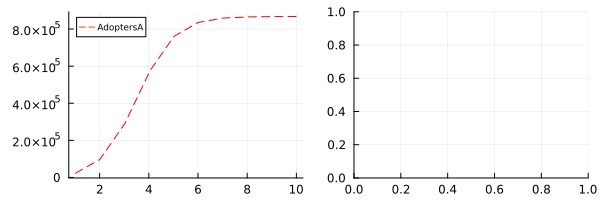

d:\Dropbox\JuliaDocs\NortonBassModel

In [5]:
using Plots
using CSV
using DataFrames 
println(pwd())
# Function to load data
function load_data(filepath)
    data = CSV.read(filepath, DataFrame)
    return data[:,1], data[:,2]
end

# Define labels and filepaths for the plots
file_labels = [("AdpotersAdata.csv", "AdoptersA", "U1[t]")
              ]

# Define indices for Y variables
#Y_indices = [1]

# Create combined plots
p_combined = plot(layout=(1,2), size=(600,200))

for i in 1:length(file_labels)
    filepath, data_label, sol_label = file_labels[i]
    # Load data
    t, y = load_data(filepath)
    # Plot data from external files
    plot!(p_combined[i], t, y, label=data_label, legendfontsize=6, linestyle=:dash, linecolor=:red)
    # Plot calculated results
   # plot!(p_combined[i], sol.t, sol[Y_indices[i],:], label=sol_label, legendfontsize=6, linecolor=:blue)
end

# Display the combined plot
display(p_combined)

Norton-Bassモデルのより進んだ最適化手法である Limited-memory Broyden–Fletcher–Goldfarb–Shanno (L-BFGS) を試す。目的関数としてハバーロス（Huber Loss）を利用する。ハバーロスは、二乗誤差と絶対誤差を組み合わせた損失関数であり、異常値の影響を受けにくい特性を持つ．

In [6]:
using Optim
using DifferentialEquations
using CSV
using DataFrames 

# Parameters
TIMESTEP = 0.015625
TMAX = 10
AverageProductLifel = 5
TotalPopulationN = 1e+06

# System of ODEs
function system!(du, u, p, t)
    AdoptersA, PotentialAdoptersP = u
    AdoptionFractioni, AdvertisingEffectivenessa, ContactRatec = p
    AdoptionfromAdvertising = AdvertisingEffectivenessa * PotentialAdoptersP
    AdoptionfromWordofMouth = ContactRatec * AdoptionFractioni * PotentialAdoptersP * AdoptersA / TotalPopulationN
    AdoptionRateAR = AdoptionfromAdvertising + AdoptionfromWordofMouth
    DiscardRate = AdoptersA / AverageProductLifel

    du[1] = AdoptionRateAR - DiscardRate
    du[2] = -AdoptionRateAR + DiscardRate
end

u0 = [0, TotalPopulationN]
tspan = (0.0, TMAX)
p_initial = [0.001, 0.001, 10]  # Adjust initial values
prob = (p) -> ODEProblem(system!, u0, tspan, p)

function load_data(filename)
    data = CSV.read(filename, DataFrame)
    t_data = data[:,1] 
    y_data = data[:,2]
    return t_data, y_data
end

# Huber loss function
function huber_loss(y_true, y_pred, δ=0.5)  # Adjust delta parameter
    return sum(abs2(x) <= δ^2 ? 0.5*x^2 : δ*(abs(x) - 0.5*δ^2) for x in (y_true - y_pred))
end

function objective(p)
    sol = solve(prob(p), Tsit5(), reltol=1e-8, abstol=1e-8)
    t_data, y_data = load_data("AdpotersAdata.csv")
    sol_interpolated = [sol(t)[1] for t in t_data]
    return huber_loss(y_data, sol_interpolated)  # Use Huber loss
end

# We use the L-BFGS algorithm and finite difference gradients
res = optimize(objective, p_initial, LBFGS(), Optim.Options(f_tol = 1e-9), autodiff = :finite)

p_optimal = Optim.minimizer(res)
println("Optimal value for AdoptionFractioni: ", p_optimal[1])
println("Optimal value for AdvertisingEffectivenessa: ", p_optimal[2])
println("Optimal value for ContactRatec: ", p_optimal[3])

┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:575
┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:575


┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:575


┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:575


┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:575


┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:575


┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:575
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=0.8495430257071528. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:589
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=0.8495721485792981. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrato

┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=1.0073485568274037. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:589
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=1.0073837128811618. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:589
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=1.0073727826861585. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:589
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=1.0073594864435809. Aborting. There is either

┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=4.729176012722445. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:589
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=1.8376877727193104. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:589
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=1.8377548081217592. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:589
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=1.8378277658379816. Aborting. There is either 

┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=2.237718373286419e-11. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:589
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=2.2376934230191196e-11. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:589
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=2.237705897777283e-11. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:589
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=8.461097581289234e-11. Aborting. Th

┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=1.6627954232659745e-8. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:589
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=1.6627775129271405e-8. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:589
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=1.6627864680469955e-8. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:589
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=6.160441369946648e-8. Aborting. Ther

┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=2.2736764776075292e-7. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:589
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=2.2736902457824367e-7. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:589
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=2.2736866519412116e-7. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:589
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=2.2737004202069177e-7. Aborting. The

┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=0.00020079257089681505. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:589
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=0.00020079196240508103. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:589
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=0.00020079317830382727. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:589
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=0.00020079135500494829. Aborting.

┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=5.8999487383087885. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:589
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=5.900694369996832. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:589
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=5.901149676710907. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:589
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=5.899493908725133. Aborting. There is either an

┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=5.900321528255655. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:589
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=9.163961842606423e-10. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:589
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=9.1638614843129e-10. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:589
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=9.163916975684963e-10. Aborting. There is 

┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=6.324450810675849e-7. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:589
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=6.324385139278327e-7. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:589
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=6.324423436364539e-7. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:589


┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=6.324412513621448e-7. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:589
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=6.324450810675858e-7. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:589
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=6.324385139278346e-7. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:589
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=6.324417974638479e-7. Aborting. There i

┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=0.00043378547130372365. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:589
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=0.0004337880981165371. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:589
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=0.00043378427703604227. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:589
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=0.0004337861875664996. Aborting. T

┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=0.0020678634129477503. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:589
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=0.0020678471597957316. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:589
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=0.00206785968239216. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:589
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=0.002067850890305924. Aborting. There 

┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=0.002067855286333942. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:589
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=5.6353898375892415. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:589
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=5.636696900015818. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:589
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=5.6362004307027425. Aborting. There is eithe

┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=3.2501962529308645e-9. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:589
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=3.250160895996033e-9. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:589
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=3.2501805772143425e-9. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:589
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=3.250176571533634e-9. Aborting. There

┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=2.1900791870264863e-6. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:589
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=2.1900568012365817e-6. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:589
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=2.1900700633956355e-6. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:589
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=2.190065924732878e-6. Aborting. Ther

┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=2.88207352921044e-5. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:589
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=2.8820454936011214e-5. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:589
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=2.882059511341076e-5. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:589
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=0.00010624567366166517. Aborting. There

┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=0.0019337073714333138. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:589
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=4.83084898114122. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:589
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=4.831689604125998. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:589
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=4.831412794724536. Aborting. There is either 

┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=5.544586775010619e-9. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:589
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=5.544526650621831e-9. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:589
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=5.544560225267176e-9. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:589
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=5.5445532000317265e-9. Aborting. There 

┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=3.6984994503262633e-6. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:589
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=3.6985218466472917e-6. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:589
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=3.698514562217759e-6. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:589
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=3.6985369585636533e-6. Aborting. Ther

┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=0.00018292743430431147. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:589
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=0.0001829257520436102. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:589
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=0.00018292659316985758. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:589
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=0.0007454707682934431. Aborting. T

┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=0.0045116980819530994. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:589
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=4.978461652352602. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:589
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=4.97936626776455. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:589
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=4.979062917686234. Aborting. There is either 

┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=6.247998443560277. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:589
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=6.247961041962108. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:589


┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:575
┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:575


┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:575


┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:575


┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:575


┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:575


┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:575


┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:575


┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:575


┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:575


┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:575
┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:575


┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:575


┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:575


Optimal value for AdoptionFractioni: 0.149991619098639
Optimal value for AdvertisingEffectivenessa: 0.010999995297904457
Optimal value for ContactRatec: 10.000560950031291


最適値を用いた時間積分結果の出力

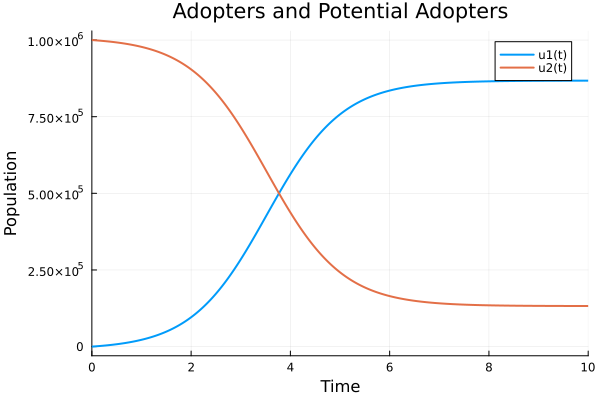

In [7]:
using Plots

# Solve the ODE problem with the optimal parameter value
sol = solve(prob(p_optimal), Tsit5(), reltol=1e-8, abstol=1e-8)

# Plot results
plot(sol, xlabel="Time", ylabel="Population", title="Adopters and Potential Adopters", lw=2)

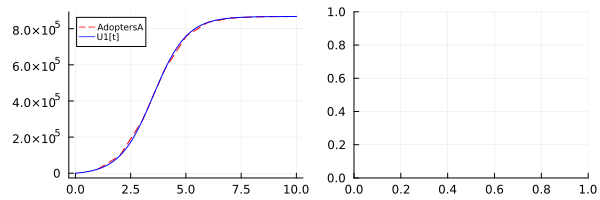

In [8]:
using Plots
using CSV
using DataFrames 

# Function to load data
function load_data(filepath)
    data = CSV.read(filepath, DataFrame)
    return data[:,1], data[:,2]
end

# Define labels and filepaths for the plots
file_labels = [("AdpotersAdata.csv", "AdoptersA", "U1[t]")
              ]

# Define indices for Y variables
Y_indices = [1]

# Create combined plots
p_combined = plot(layout=(1,2), size=(600,200))

for i in 1:length(file_labels)
    filepath, data_label, sol_label = file_labels[i]
    # Load data
    t, y = load_data(filepath)
    # Plot data from external files
    plot!(p_combined[i], t, y, label=data_label, legendfontsize=6, linestyle=:dash, linecolor=:red)
    # Plot calculated results
   plot!(p_combined[i], sol.t, sol[Y_indices[i],:], label=sol_label, legendfontsize=6, linecolor=:blue)
end

# Display the combined plot
display(p_combined)

データフレーム用パッケージの追加

各データセットに対して決定係数(R^2)、Theilの不等式統計（Um, Us, Uc）、平均絶対誤差（MAE）、平均二乗誤差（MSE）、そして平均絶対パーセント誤差（MAPE）を計算し、結果をDataFrameに保存する。その後、DataFrameの内容を出力する。ここで、各行は特定のデータセットに対応し、各列は誤差指標に対応する。

各変数の時系列変化値を表形式で表示する

In [9]:
using Statistics
using DataFrames
using Interpolations

# Function to load data
function load_data(filepath)
    data = CSV.read(filepath, DataFrame)
    return data[:,1], data[:,2]
end

# Define labels and filepaths for the plots
file_labels = [("AdpotersAdata.csv", "AdoptersA", "U1[t]")]

# Define indices for Y variables
Y_indices = [1]

# Define DataFrame for storing error metrics
error_metrics_df = DataFrame(
    DataLabel = String[], 
    NumberOfDataPoints = Int64[], # Add field for number of data points
    R2 = Float64[],  # R^2 (Coefficient of determination)
    Um = Float64[],  # Theil's inequality statistics
    Us = Float64[],
    Uc = Float64[],
    MAE = Float64[], 
    MSE = Float64[], 
    MAPE = Float64[]
)

for i in 1:length(file_labels)
    filepath, data_label, sol_label = file_labels[i]
    # Load data
    t, y = load_data(filepath)
    # Record the number of data points
    num_data_points = length(t)
    # Get the range of time values for which data exists
    t_min, t_max = minimum(t), maximum(t)
    # Filter sol's time points to the range of time values for which data exists
    sol_indices = (sol.t .>= t_min) .& (sol.t .<= t_max)
    sol_t, sol_y = sol.t[sol_indices], sol[Y_indices[i],sol_indices]
    # Interpolate the numerical solution to match the time steps of the loaded data
    interp_func = LinearInterpolation(sol_t, sol_y, extrapolation_bc=Line())
    sol_y_interp = interp_func.(t)
    # Compute the errors
    errors = abs.(y - sol_y_interp)
    # Compute MAE, MSE, and MAPE
    mae = mean(errors)
    mse = mean(errors.^2)
    mape = mean(errors ./ abs.(y)) * 100
    # Compute R-squared (coefficient of determination)
    ss_total = sum((y .- mean(y)).^2)
    ss_res = sum((y .- sol_y_interp).^2)
    r2 = 1 - ss_res/ss_total
    # Compute Theil's inequality statistics
    y_mean = mean(y)
    sol_y_interp_mean = mean(sol_y_interp)
    um = sqrt(sum((y - sol_y_interp).^2)) / (sqrt(sum((y.^2)) + sqrt(sum((sol_y_interp).^2))))
    us = sqrt(sum(((y .- y_mean) .- (sol_y_interp .- sol_y_interp_mean)).^2)) / sqrt(sum((y .- y_mean).^2))
    uc = sqrt(sum(((y .- y_mean) .+ (sol_y_interp .- sol_y_interp_mean)).^2)) / sqrt(sum((y .+ sol_y_interp).^2))
    
    # Check if um + us + uc is close to 1, if not adjust the values
    total = um + us + uc
    if abs(total - 1) > 1e-6
        um /= total
        us /= total
        uc /= total
    end
    
    # Append the computed error metrics to the DataFrame
    push!(error_metrics_df, (data_label, num_data_points, r2, um, us, uc, mae, mse, mape))
end

# Print the DataFrame containing R^2, Theil's inequality statistics, MAE, MSE, and MAPE values
println(error_metrics_df)
#
CSV.write("error_metrics7.csv", error_metrics_df)

1×9 DataFrame
 Row │ DataLabel  NumberOfDataPoints  R2       Um          Us         Uc        MAE      MSE      MAPE       
     │ String     Int64               Float64  Float64     Float64    Float64   Float64  Float64  Float64    
─────┼───────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │ AdoptersA                  10      1.0  1.36069e-5  2.8791e-5  0.999958  3.03316  19.3372  0.00142539


"error_metrics7.csv"